In [94]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import FunctionTransformer

#Load in the resampled dataset
df = pd.read_csv('data/processed/hourly_pollutionpatterns.csv').set_index('DATETIME')

# Including harmonic signals
def sin_encoder(period):
        return FunctionTransformer(lambda x: np.sin((2 * np.pi* x)/period))

def cos_encoder(period):

    return FunctionTransformer(lambda x: np.cos((2 * np.pi* x)/period))

def adding_remaining_features(df):

    df.index = pd.to_datetime(df.index, utc=True)

    pollutants = ["TOC", "TN", "TP", "SS"]

    df["sine"] = sin_encoder(24).fit_transform(df.index.hour)
    df["cosine"] = cos_encoder(24).fit_transform(df.index.hour)

    # Including day of week
    df["is_weekend"] = df.index.dayofweek.isin([5, 6]).astype(int)

    # Taking the logarithm of Pollutants
    logcn = lambda x: f"log{x}"
    logpollutants = []
    for p in pollutants:
        cn = logcn(p)
        df[cn] = np.log(1 + df[p].divide(df[p].max()))
        logpollutants.append(cn)

    return df

#The function
def dataProcessing_Chunks(inputdf,features,hours_ahead,hours_behind):
    for feature in features:
        for i in range(1,hours_ahead+1,1):
            inputdf[f'{feature}+{i}'] = inputdf[f'{feature}'].shift(-i)
    for feature in features:
        for i in range(1,hours_behind+1,1):
            inputdf[f'{feature}-{i}'] = inputdf[f'{feature}'].shift(i)   
    inputdf.dropna(inplace=True)
    return inputdf
  
#Use the function
fetures_shift = ['TOC','TN','TP','SS','Rain']
df_chunks = dataProcessing_Chunks(df,fetures_shift,6,6)
df_chunks = adding_remaining_features(df_chunks)

In [95]:
def split_dataset(inputdf,features_drop,hours_ahead):
    holder = []
    for feature in features_drop:
        for i in range(1,hours_ahead+1,1):
            holder.append(f'{feature}+{i}')
    X1 = inputdf.drop(holder, axis=1)
    y1 = inputdf[holder]
    return X1, y1

fetures_drop = ['TOC','TN','TP','SS']
X, y = split_dataset(df_chunks,fetures_drop,6)

In [96]:
X.reset_index(inplace=True)
X = X.drop(['DATETIME'],axis=1)

In [97]:
X.columns

Index(['TOC', 'TN', 'TP', 'SS', 'Flow', 'Bypass', 'Rain', 'Rain+1', 'Rain+2',
       'Rain+3', 'Rain+4', 'Rain+5', 'Rain+6', 'TOC-1', 'TOC-2', 'TOC-3',
       'TOC-4', 'TOC-5', 'TOC-6', 'TN-1', 'TN-2', 'TN-3', 'TN-4', 'TN-5',
       'TN-6', 'TP-1', 'TP-2', 'TP-3', 'TP-4', 'TP-5', 'TP-6', 'SS-1', 'SS-2',
       'SS-3', 'SS-4', 'SS-5', 'SS-6', 'Rain-1', 'Rain-2', 'Rain-3', 'Rain-4',
       'Rain-5', 'Rain-6', 'sine', 'cosine', 'is_weekend', 'logTOC', 'logTN',
       'logTP', 'logSS'],
      dtype='object')

In [98]:
y.columns

Index(['TOC+1', 'TOC+2', 'TOC+3', 'TOC+4', 'TOC+5', 'TOC+6', 'TN+1', 'TN+2',
       'TN+3', 'TN+4', 'TN+5', 'TN+6', 'TP+1', 'TP+2', 'TP+3', 'TP+4', 'TP+5',
       'TP+6', 'SS+1', 'SS+2', 'SS+3', 'SS+4', 'SS+5', 'SS+6'],
      dtype='object')

In [99]:
X_train = X[:20000]
X_test = X[20000:26683]
y_train = y[:20000]
y_test = y[20000:26683]

In [86]:
y_test.shape

(6683, 24)

In [8]:
X_train.shape

(20000, 50)

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2
import matplotlib.pyplot as plt

# Reshape input data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], 10, 5))
X_test = np.reshape(X_test, (X_test.shape[0], 10, 5))

# Build LSTM model
lstm_model = Sequential()
#lstm_model.add(LSTM(64, input_shape=(X_train.shape[1], 1), activation='relu', kernel_regularizer=l2(0.01)))
lstm_model.add(LSTM(64, input_shape=(10, 5), activation='relu', kernel_regularizer=l2(0.01)))
lstm_model.add(Dropout(0.05))
lstm_model.add(Dense(24, activation='linear'))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model and get history
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()



In [ ]:
# Make predictions
lstm_y_pred = lstm_model.predict(X_test)

In [ ]:
dflstm_y_pred = pd.DataFrame(lstm_y_pred, columns=y_test.columns)
dflstm_y_pred

In [75]:
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(32, return_sequences=True,input_shape=[]),
#     tf.keras.layers.Dense(14)
# ])

# Reshape input data for LSTM
# X_train = np.reshape(X_train, (X_train.shape[0], 10, 5))
# X_test = np.reshape(X_test, (X_test.shape[0], 10, 5))

def create_dataset(X, y, time_steps=1, future = 0):
    Xs, ys = [], []
        
        
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps + future])
    return np.array(Xs), np.array(ys)
# above formats the data for a lstm so that we predict to the next timestep

X_train, y_train = create_dataset(X_train,y_train, time_steps= 25)
X_test, y_test = create_dataset(X_test,y_test, time_steps= 25)


es_callback = EarlyStopping(monitor='val_loss', patience=2)

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_out1 = LSTM(128, return_sequences=False)(inputs)
dropout1 = Dropout(0.30)(lstm_out1)
outputs = Dense(24)(dropout1)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')



## checkpoints # name your model here:
checkpoint_path = "models/1_layer_128_logging_y.keras"
model_checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    filepath=checkpoint_path,
    save_weights_only=False,
    save_best_only=True)

## print visible paths
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)
else:
    history = model.fit(X_train, y_train, epochs=10, batch_size=12, validation_split=0.2, shuffle=False, callbacks=[es_callback, model_checkpoint_callback])

Epoch 1/10
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - loss: 3402.9385 - val_loss: 1293.8364
Epoch 2/10
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - loss: 1240.3119 - val_loss: 890.3931
Epoch 3/10
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 30s 23ms/step - loss: 1017.5261 - val_loss: 785.5430
Epoch 4/10
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - loss: 955.2706 - val_loss: 748.1404
Epoch 5/10
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - loss: 935.0604 - val_loss: 729.3752
Epoch 6/10
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - loss: 934.3197 - val_loss: 719.6304
Epoch 7/10
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - loss: 915.7416 - val_loss: 695.3347
Epoch 8/10
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 30s 23ms/step - loss: 913.4376 - val_loss: 693.9734
Epoch 9/10
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - loss: 901.6696 - val_loss: 691.1208
Epoch 10/10
1332/1332 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - loss: 895.6238 - val_loss: 709.2815


In [89]:
# Make predictions
lstm_y_pred = model.predict(X_test)

ValueError: as_list() is not defined on an unknown TensorShape.

In [93]:
dflstm_y_pred = pd.DataFrame(lstm_y_pred, columns=y.columns)
dflstm_y_pred

,TOC+1,TOC+2,TOC+3,TOC+4,TOC+5,TOC+6,TN+1,TN+2,TN+3,TN+4,...,TP+3,TP+4,TP+5,TP+6,SS+1,SS+2,SS+3,SS+4,SS+5,SS+6
0,162.348618,161.270859,160.768875,159.279419,159.118835,158.659882,44.764572,44.801323,44.659821,44.695778,...,4.742009,4.861078,4.627278,4.677437,0.524682,0.516433,0.508494,0.514194,0.513830,0.511689
1,158.678757,157.781570,157.352432,155.911819,155.861420,155.339462,43.396671,43.555790,43.484245,43.416912,...,4.440768,4.433407,4.379881,4.208659,0.503563,0.495449,0.488715,0.492518,0.490754,0.488849
2,158.734207,157.802246,157.385880,155.926697,155.874847,155.383560,43.380108,43.548481,43.480057,43.455471,...,4.364379,4.376368,4.270784,4.104589,0.509039,0.501530,0.495234,0.498820,0.497485,0.496023
3,160.605148,159.572098,158.989655,157.672424,157.452423,157.053101,44.210766,44.251411,44.243214,44.281837,...,4.419191,4.605651,4.335875,4.360853,0.517969,0.510074,0.501744,0.507072,0.508143,0.504307
4,167.915283,166.928482,166.371933,164.776230,164.384216,163.922806,46.275814,46.393097,46.202126,46.308414,...,5.504164,5.706988,5.464908,5.393026,0.555269,0.551119,0.548004,0.553263,0.551471,0.553544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6653,70.538689,71.637299,71.632118,72.738953,73.231544,73.202888,18.576351,18.879793,19.246593,19.400608,...,0.905488,1.068759,1.445320,1.080682,0.174186,0.175348,0.181096,0.189940,0.195160,0.198421
6654,71.631935,72.724373,72.672806,73.805046,74.253090,74.211899,18.907486,19.240774,19.568207,19.739302,...,0.931650,1.059432,1.445999,1.079050,0.172743,0.173546,0.178567,0.187761,0.193804,0.197118
6655,72.801697,73.888123,73.800133,74.875229,75.323776,75.299614,19.216022,19.567747,19.899025,20.055243,...,0.915214,1.014101,1.409747,1.077713,0.173103,0.173103,0.177701,0.187148,0.194220,0.198172
6656,77.300209,78.261810,78.058792,78.968918,79.235703,79.277901,20.593590,20.898020,21.207085,21.320541,...,1.582777,1.641297,1.882156,1.779113,0.183224,0.182245,0.187001,0.195590,0.202681,0.208714


## Compare the outputs to orginals

ValueError: x and y must have same first dimension, but have shapes (6683,) and (6658,)

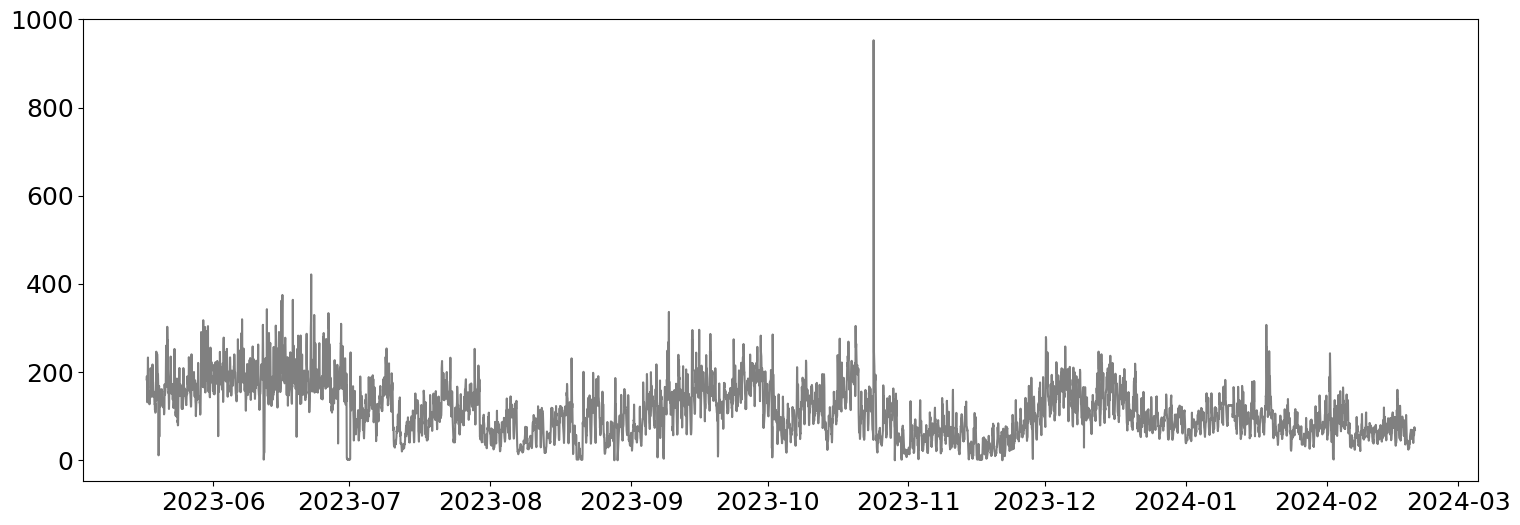

In [91]:
import matplotlib.pyplot as plt

#--------------------------------------------------------------------
#select the feature, and the forcast length to compare:
feature = 'TOC'
forcastlength = 1
#--------------------------------------------------------------------

TS = f'{feature}+{forcastlength}'
#linier graph for Test section
time=y_test.index
plt.rcParams.update({'font.size': 18})
fig, ax1 = plt.subplots(figsize=(18,6), )

plt.plot(time,y_test[TS], color = 'gray', label = 'Actual')
plt.plot(time,dflstm_y_pred[TS], color = 'green', label = TS)

plt.xlabel("Time (hour)")
plt.ylabel(f'{feature} (Mg/l)')
plt.legend(loc='upper center', mode='expand',ncol=5)
plt.show()

In [103]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

fetures = ['TOC','TN','TP','SS']

for feature in fetures:
    for i in range(1,7,1):
        index = f'{feature}+{i}'
        xgb_stat = mean_squared_error(y_test[:6658][index], dflstm_y_pred[index],squared=False) #Just copy one of the functions in the first line for different comparisions
        print(f'{index}: {xgb_stat}')
    print('--------------------------')

TOC+1: 44.40829387147311
TOC+2: 44.670861075927064
TOC+3: 44.8510560835014
TOC+4: 45.15466574770278
TOC+5: 45.36066140093777
TOC+6: 45.433638925698226
--------------------------
TN+1: 11.597963364330864
TN+2: 11.630319213892038
TN+3: 11.723356595978688
TN+4: 11.839987175915914
TN+5: 11.900986763663923
TN+6: 11.939570101151492
--------------------------
TP+1: 6.588154404954698
TP+2: 6.605428676104357
TP+3: 6.553106126743279
TP+4: 6.512444074248996
TP+5: 6.5073981451889615
TP+6: 6.520397988940748
--------------------------
SS+1: 0.9874634009966171
SS+2: 0.9880646111024456
SS+3: 0.9876145946774791
SS+4: 0.9872844621051823
SS+5: 0.9876036802796653
SS+6: 0.9875590443103708
--------------------------


c:\Users\chga\source\repos\MLHackathon24_PollutionPatterns\pollutionpatterns\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\chga\source\repos\MLHackathon24_PollutionPatterns\pollutionpatterns\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\chga\source\repos\MLHackathon24_PollutionPatterns\pollutionpatterns\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\chga\source\repos\MLHackathon24_PollutionPatte

In [101]:
y_test[:6658]

,TOC+1,TOC+2,TOC+3,TOC+4,TOC+5,TOC+6,TN+1,TN+2,TN+3,TN+4,...,TP+3,TP+4,TP+5,TP+6,SS+1,SS+2,SS+3,SS+4,SS+5,SS+6
DATETIME,,,,,,,,,,,,,,,,,,,,,
2023-05-17 09:00:00+00:00,183.506250,190.303125,187.667708,140.145833,131.532292,166.272917,47.087032,45.181354,45.342500,38.335208,...,15.635594,9.778562,9.245615,9.148927,1.275812,1.146693,0.594822,0.416798,0.459787,0.492239
2023-05-17 10:00:00+00:00,190.303125,187.667708,140.145833,131.532292,166.272917,185.696875,45.181354,45.342500,38.335208,35.045208,...,9.778562,9.245615,9.148927,8.583240,1.146693,0.594822,0.416798,0.459787,0.492239,0.721165
2023-05-17 11:00:00+00:00,187.667708,140.145833,131.532292,166.272917,185.696875,233.103125,45.342500,38.335208,35.045208,35.211093,...,9.245615,9.148927,8.583240,9.123990,0.594822,0.416798,0.459787,0.492239,0.721165,0.670277
2023-05-17 12:00:00+00:00,140.145833,131.532292,166.272917,185.696875,233.103125,184.062500,38.335208,35.045208,35.211093,37.204634,...,9.148927,8.583240,9.123990,7.695479,0.416798,0.459787,0.492239,0.721165,0.670277,0.508727
2023-05-17 13:00:00+00:00,131.532292,166.272917,185.696875,233.103125,184.062500,136.216667,35.045208,35.211093,37.204634,43.219531,...,8.583240,9.123990,7.695479,6.259021,0.459787,0.492239,0.721165,0.670277,0.508727,0.429018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-19 05:00:00+00:00,37.987500,43.354167,36.884375,48.981250,55.116667,58.793750,7.814479,10.082552,12.192396,14.392292,...,0.809229,1.335615,1.195104,1.197292,0.062352,0.072663,0.086105,0.129635,0.132081,0.131460
2024-02-19 06:00:00+00:00,43.354167,36.884375,48.981250,55.116667,58.793750,61.950000,10.082552,12.192396,14.392292,16.297239,...,1.335615,1.195104,1.197292,2.003385,0.072663,0.086105,0.129635,0.132081,0.131460,0.132513
2024-02-19 07:00:00+00:00,36.884375,48.981250,55.116667,58.793750,61.950000,62.884375,12.192396,14.392292,16.297239,15.636979,...,1.195104,1.197292,2.003385,1.488083,0.086105,0.129635,0.132081,0.131460,0.132513,0.135211
